### Goal of this notebook is to build a model that predicts whether an ad will be clicked or not. We will use a random forest classifier and various deep models for comparison

# RANDOM FOREST

### Importing Necessary Libraries

In [1]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, precision_score, recall_score, accuracy_score, f1_score, make_scorer, confusion_matrix
from sklearn.externals import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
df = pd.read_csv('avazu_sample.gz')

**File is also available here**

In [ ]:
# df = pd.read_csv('https://raw.githubusercontent.com/harish-cu/applied_deep_learning/master/dl_project/data/dl_project_avazu_sample')

### Creating the hour of the day field

In [3]:
## Choose one at some point - currently choosing numeric but if trees are not being used, change accordingly
# Using hour as a categorical variable
# df['hr'] = df['hour'].apply(lambda x:str(x)[-2:])
# Using hour as a numeric variable
df['hr'] = df['hour'].apply(lambda x:x%100)

### Removing device id and device ip (discarding user identifiers) for this model. Also removing the ad id and the datehour column

In [4]:
df = df.drop(labels=['id', 'hour', 'device_id', 'device_ip'], axis=1)

### Function to keep the most occuring values for each category and assigning the rest to an others bucket. Limits the max number of values for a categorical field to a small number.

In [5]:
def convert_to_other(df, col, drop):
    cnts = df[col].value_counts(normalize=True).reset_index().rename(columns={'index':col, col:'perc'})
    cnts[col+'_updated'] = cnts.apply(lambda x:x[col] if x.name<100 and x.perc>=0.01 else 'other', axis=1)
    cnts = cnts[[col, col+'_updated']]
    df = pd.merge(df, cnts, on=col, how='inner')
    if drop:
        df.drop(col, axis=1, inplace=True)
        df = df.rename(columns={col+'_updated':col})
    return df

### Applying the above function to all features except the response variable - click

In [6]:
for col in df.columns:
    if col!='click':
        df = convert_to_other(df, col=col, drop=True)

### One-hot encoding the categorical fields after creation of the other bucket

In [7]:
df_dummies = pd.get_dummies(df, columns=['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_model', 'device_type',
       'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21'])

### Stratified sample (based on target) to maintain original ratio of clicks and non clicks for the validation and test dataset.

In [8]:
df_train, df_test = train_test_split(df_dummies, test_size=0.2, stratify=df_dummies['click'], random_state=20)

In [9]:
df_train, df_val = train_test_split(df_train, test_size=0.2, stratify=df_train['click'], random_state=20)

### Splitting into features and response variable

In [10]:
X_train = df_train[list(set(df_train.columns) - set(['click']))]
y_train = df_train['click']

X_val = df_val[list(set(df_val.columns) - set(['click']))]
y_val = df_val['click']

X_test = df_test[list(set(df_test.columns) - set(['click']))]
y_test = df_test['click']

### Grid Search Function to find the best estimator for a chosen score function

In [11]:
def grid_search_func(model, X, y, folds, param_grid, scorers, refit_score):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    """
    skf = StratifiedKFold(n_splits=5)
    grid_search = GridSearchCV(model, param_grid=param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X.values, y.values)
    return grid_search

### Defining a random forest model and searching the parameter grid for the best parameters for the given score function

In [12]:
model = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [5, 10], 
    'n_estimators' : [50, 100],
    'max_depth': [15, 20, 25, 40]
}

scorers = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'log_loss': make_scorer(log_loss)
}

### Running the model to optimize for f1 score

In [13]:
grid_search_clf = grid_search_func(model=model, X=X_train, y=y_train, folds=5, param_grid=param_grid,\
                                   scorers=scorers, refit_score='f1')

### Printing parameters of the best model

In [14]:
for key, value in grid_search_clf.best_params_.items() :
    print (key, ":", value)

min_samples_split : 5
n_estimators : 50
max_depth : 40


### Printing all results from the grid search

In [15]:
pd.DataFrame(grid_search_clf.cv_results_).iloc[:,[12,13,14, 2,3,4,5,6]]

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_accuracy,mean_test_f1,mean_test_log_loss,mean_test_precision,mean_test_recall
0,15,5,50,0.863088,0.033700,4.728791,0.651976,0.017299
1,15,5,100,0.863166,0.034061,4.726093,0.662923,0.017480
2,15,10,50,0.863109,0.032808,4.728036,0.660100,0.016823
3,15,10,100,0.863213,0.033217,4.724474,0.677603,0.017027
4,20,5,50,0.862041,0.056101,4.764951,0.503446,0.029707
5,20,5,100,0.862091,0.055191,4.763224,0.506507,0.029186
6,20,10,50,0.862628,0.047902,4.744659,0.550513,0.025042
7,20,10,100,0.862628,0.047036,4.744659,0.552610,0.024567
8,25,5,50,0.859866,0.080314,4.840076,0.426279,0.044334
9,25,5,100,0.859922,0.079962,4.838134,0.427450,0.044107


## Saving model for easier loading in the future

In [16]:
best_rf_model = grid_search_clf.best_estimator_

In [17]:
# save the model to disk
filename = 'best_rf_model.sav'
joblib.dump(best_rf_model, filename)

['best_rf_model.sav']

### Loading saved model - Use this directly if you don't want to retrain the model

In [18]:
# filename = 'best_rf_model.sav'
# best_rf_model = joblib.load(filename)

### Making predictions on the validation dataset using the chosen model

In [19]:
y_pred_val = best_rf_model.predict(X_val)
y_prob_val = best_rf_model.predict_proba(X_val)

### Printing performance metrics for the chosen model using the default threshold of 0.5

In [20]:
print('Log Loss: {0:.4f}'.format(log_loss(y_val, y_prob_val)))
print('Accuracy: {0:.4f}'.format(accuracy_score(y_val, y_pred_val)))
print('Precision: {0:.4f}'.format(precision_score(y_val, y_pred_val)))
print('Recall: {0:.4f}'.format(recall_score(y_val, y_pred_val)))
print('F1 Score: {0:.4f}'.format(f1_score(y_val, y_pred_val)))

Log Loss: 0.5181
Accuracy: 0.8532
Precision: 0.3402
Recall: 0.0677
F1 Score: 0.1130


### Extracting Variable Importance

In [21]:
importance = pd.DataFrame(best_rf_model.feature_importances_, index=X_train.columns, 
                          columns=["importance"]).reset_index().rename(columns={'index':'feature'})

importance.sort_values('importance', inplace=True, ascending=False)
importance = importance.reset_index(drop=True)

### Printing top 10 variables based on importance

In [22]:
importance.sort_values('importance', ascending=False)[:10]

,feature,importance
0,hr,0.506192
1,device_model_other,0.018945
2,C20_-1.0,0.017018
3,C21_15.0,0.012865
4,C20_other,0.012203
5,device_conn_type_0.0,0.008664
6,app_id_other,0.008050
7,app_category_0f2161f8,0.007709
8,C19_39.0,0.007490
9,C19_35.0,0.007143


### Aggregating importance across one-hot variables of original features

In [23]:
importances = {}
for col in df.columns:
    if col != 'click':
        importances[col]= sum(importance[importance['feature'].str.contains(col)==True]['importance'])

In [24]:
importances = pd.DataFrame.from_dict(importances, orient='index')
importances.columns=['importance']

### Printing top 10 variables based on importance

In [25]:
importances.sort_values('importance', ascending=False)[:10]

,importance
hr,0.506192
C1,0.141337
device_model,0.088170
C20,0.061808
C21,0.056197
C19,0.047565
app_id,0.034221
C17,0.031570
app_category,0.026527
app_domain,0.021134


## Plotting Variable Importance

In [26]:
top_var_imp = importances.sort_values('importance', ascending=False)[:10].reset_index()
top_var_imp.columns = [['feature','importance']]
top_var_imp.sort_values('importance', inplace=True)

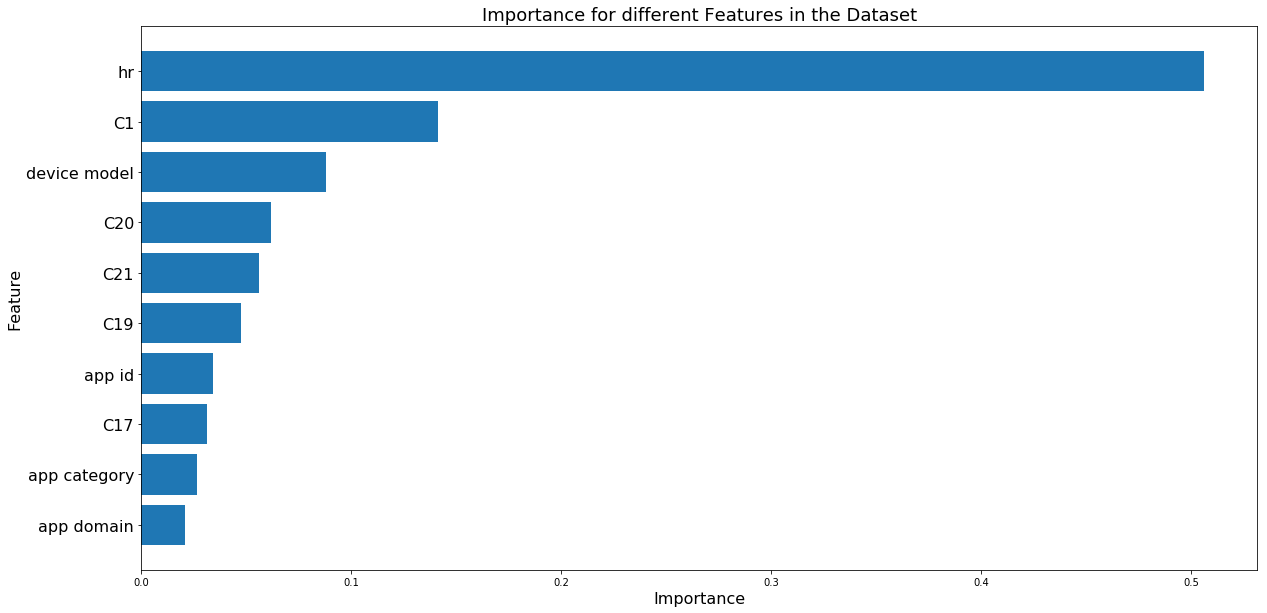

In [27]:
plt.figure(figsize=(20,10))
plt.barh(range(len(top_var_imp)), width=top_var_imp['importance'])
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.yticks(range(len(top_var_imp)), [x.replace('_',' ') for x in top_var_imp['feature']], rotation=0, fontsize=16)
plt.title('Importance for different Features in the Dataset', fontsize=18)
plt.show()

## EDA Plot to check CTR for different values of Features

In [28]:
def eda_plot(df, col, name, chart_title, col_int='click'):
    col_dist = df.groupby(col)[col_int].agg(['sum', 'count']).reset_index()
    col_dist['ctr'] = col_dist['sum']/col_dist['count']
    print('Number of unique values:', len(col_dist))

    fig, ax1 = plt.subplots(figsize=(20,8))
    ax2 = ax1.twinx()
    ax1.plot(range(len(col_dist['count'])), col_dist['count'], 'b-')
    ax2.plot(range(len(col_dist['ctr'])), col_dist['ctr'], 'r-')
    ax1.set_xlabel(name, fontsize=16)
    ax1.set_ylabel('Impressions', color='b', fontsize=16)
    ax2.set_ylabel('CTR', color='r', fontsize=16)
    plt.xticks(range(len(col_dist['count'])))
    plt.title(chart_title, fontsize=18)

    plt.grid('off')

Number of unique values: 24


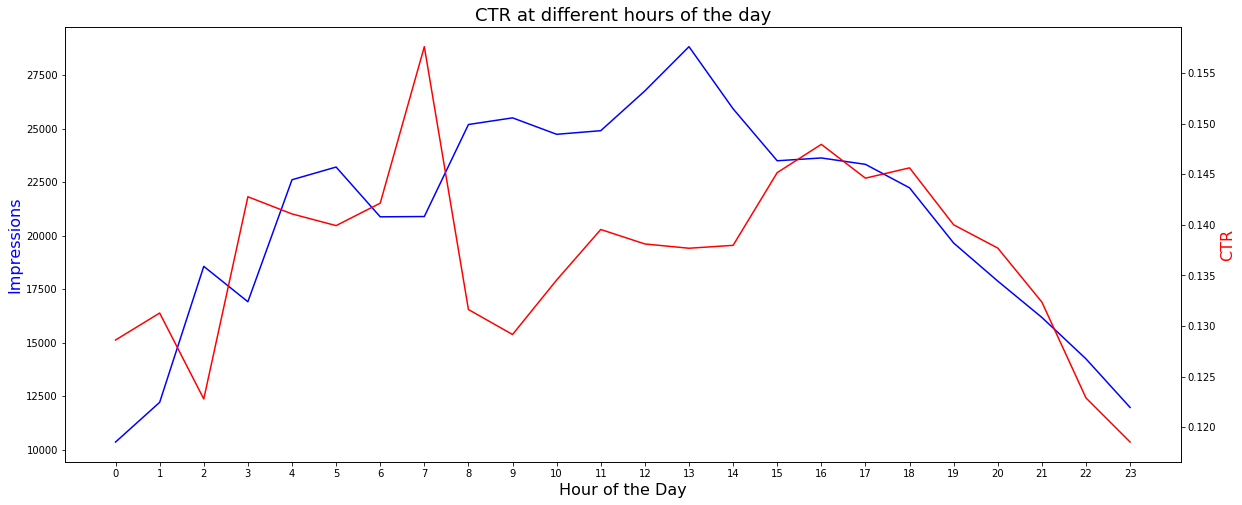

In [29]:
eda_plot(df, col='hr', name='Hour of the Day', chart_title='CTR at different hours of the day')

In [30]:
# eda_plot(df, col='C1', name='C1', chart_title='CTR at different values of C1')

### Histogram of prediction probabilities

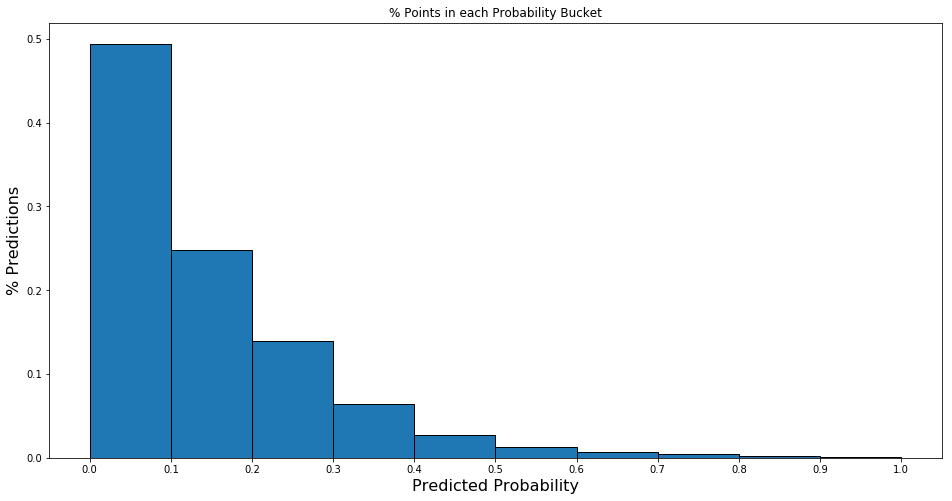

In [31]:
plt.figure(figsize=(16,8))
plt.hist(y_prob_val[:,1], edgecolor='Black', weights = np.ones_like(y_prob_val[:,1])/float(len(y_prob_val[:,1])))
plt.xlabel('Predicted Probability', fontsize=16)
plt.ylabel('% Predictions', fontsize=16)
plt.title('% Points in each Probability Bucket')
plt.xticks([x/10 for x in range(0,11)])
plt.show()

### Applying different thresholds for positive class to check the impact on precision and recall

In [32]:
threshold_metrics = {}
for threshold in [x/10 for x in range(1,10)]:
    threshold_metrics[threshold]={}
    pred_val = (y_prob_val[:,1] >= threshold).astype('int')
    threshold_metrics[threshold]['accuracy'] = accuracy_score(y_val, pred_val)
    threshold_metrics[threshold]['precision'] = precision_score(y_val, pred_val)
    threshold_metrics[threshold]['recall'] = recall_score(y_val, pred_val)
    threshold_metrics[threshold]['f1'] = f1_score(y_val, pred_val)

In [33]:
threshold_metrics = pd.DataFrame(threshold_metrics).T

In [34]:
threshold_metrics.round(decimals=3)

,accuracy,f1,precision,recall
0.1,0.551,0.302,0.192,0.704
0.2,0.724,0.303,0.233,0.434
0.3,0.807,0.248,0.269,0.231
0.4,0.840,0.172,0.303,0.120
0.5,0.853,0.113,0.340,0.068
0.6,0.859,0.077,0.400,0.043
0.7,0.861,0.048,0.456,0.026
0.8,0.862,0.024,0.517,0.012
0.9,0.862,0.011,0.618,0.006


### Precision and Recall Curves Plot

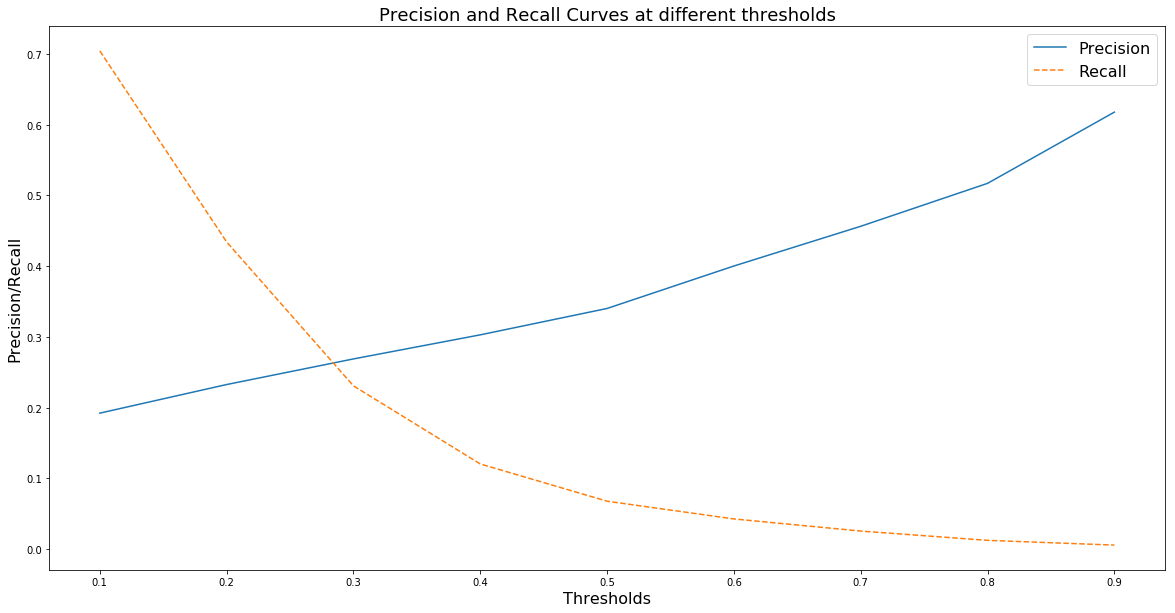

In [35]:
plt.figure(figsize=(20,10))
plt.plot([x/10 for x in range(1,10)], threshold_metrics['precision'],
                 label='Precision')
plt.plot([x/10 for x in range(1,10)], threshold_metrics['recall'], '--',
           label='Recall')
plt.xlabel('Thresholds', fontsize=16)
plt.xticks([x/10 for x in range(1,10)])
plt.ylabel('Precision/Recall', fontsize=16)
plt.legend(loc=1, prop={'size': 16})
plt.title('Precision and Recall Curves at different thresholds', fontsize=18)
plt.show()

### Based on the above curve, a threshold that satisfies our needs can be chosen. A threshold of around 0.32 seems to provide a good balance between precision and recall rates. Given this is an imbalanced dataset with ~14% of 1s, a good balance for a useful model seems to be to get about ~30% precision and ~20% recall

### Precision vs Recall Curve

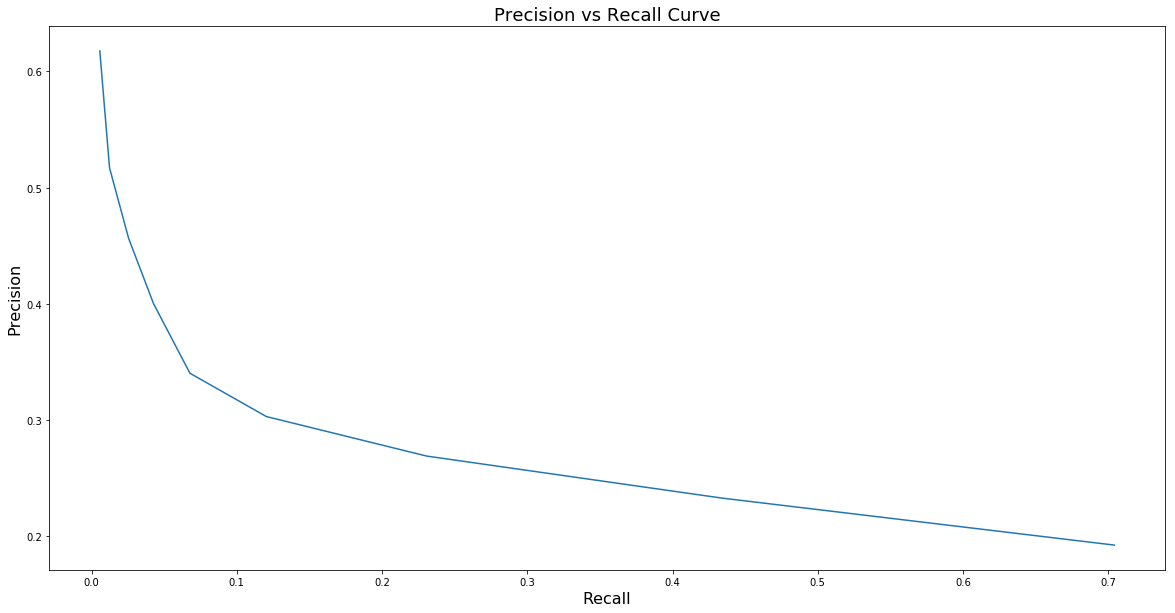

In [36]:
plt.figure(figsize=(20,10))
plt.plot(threshold_metrics['recall'], threshold_metrics['precision'],
                 label='Precision')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision vs Recall Curve', fontsize=18)
plt.show()

### Selected Model precision and recall

In [37]:
pred_val = (y_prob_val[:,1] >= 0.32).astype('int')
print('Model Precision: {0:.3f}'.format(precision_score(y_val, pred_val)))
print('Model Recall: {0:.3f}'.format(recall_score(y_val, pred_val)))

Model Precision: 0.273
Model Recall: 0.201


### Now, performance of baseline and the selected model on the test dataset

### Baseline for precision

In [38]:
%%capture --no-stdout
print('All 0s: {0:.3f}'.format(precision_score(y_test, np.zeros(len(y_test)))))
print('All 1s: {0:.3f}'.format(precision_score(y_test, np.ones(len(y_test)))))
print('Random prediction baseline: {0:.3f}'.format(precision_score(y_test, np.random.randint(2, size=len(y_test)))))

All 0s: 0.000
All 1s: 0.138
Random prediction baseline: 0.138


In [39]:
y_pred_test = best_rf_model.predict(X_test)
y_prob_test = best_rf_model.predict_proba(X_test)
pred_test = (y_prob_test[:,1] >= 0.32).astype('int')

In [40]:
print('Log Loss: {0:.4f}'.format(log_loss(y_test, pred_test)))
print('Accuracy: {0:.4f}'.format(accuracy_score(y_test, pred_test)))
print('Precision: {0:.4f}'.format(precision_score(y_test, pred_test)))
print('Recall: {0:.4f}'.format(recall_score(y_test, pred_test)))
print('F1 Score: {0:.4f}'.format(f1_score(y_test, pred_test)))

Log Loss: 6.3186
Accuracy: 0.8171
Precision: 0.2769
Recall: 0.2020
F1 Score: 0.2336


# DEEP MODELS

### Importing Necessary Libraries

In [41]:
import pandas as pd
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, precision_score, recall_score, accuracy_score, f1_score, make_scorer, confusion_matrix
from tensorflow.python.feature_column import feature_column_v2 as fc

from sklearn.utils import shuffle
from six.moves import urllib
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.manifold import TSNE

tf.enable_eager_execution()

## Data Preparation
* The data preparation for the DNN portion is similar to the data preparation for the RF Model
* For the model with categorical embeddings, the raw data isn't bucketed

In [45]:
sample_df = pd.read_csv('avazu_sample.gz')

**File is also available here**

In [ ]:
# sample_df = pd.read_csv('https://raw.githubusercontent.com/harish-cu/applied_deep_learning/master/dl_project/data/dl_project_avazu_sample')

In [46]:
# Create new feature for HR component & convert label feature into float
sample_df['hr'] = sample_df['hour'].astype(str).str[6:].astype(np.int64)
sample_df['click'] = sample_df['click'].astype(float)

In [47]:
# This dataframe will be used for one hot encodings
sample_df = sample_df.drop(labels=['id', 'hour', 'device_id', 'device_ip'], axis=1)

In [48]:
# This dataframe will be used for embeddings
sample_df_1 = sample_df.copy()

In [49]:
def convert_to_other(df, col, drop, val):
    cnts = df[col].value_counts(normalize=True).reset_index().rename(columns={'index':col, col:'perc'})
    cnts[col+'_updated'] = cnts.apply(lambda x:x[col] if x.name<100 and x.perc>=0.01 else val, axis=1)
    cnts = cnts[[col, col+'_updated']]
    df = pd.merge(df, cnts, on=col, how='inner')
    if drop:
        df.drop(col, axis=1, inplace=True)
        df = df.rename(columns={col+'_updated':col})
    return df

In [50]:
for col in sample_df.columns:
    if col!='click':
      if col in ('C1', 'C14', 'C15', 'C16','C17','C18','C19','C20','C21','banner_pos','device_type', 'device_conn_type', 'hr'):
        sample_df = convert_to_other(sample_df, col=col, drop=True, val=12345.0)
        sample_df[col] = sample_df[col].astype('int32')
      else:
        sample_df = convert_to_other(sample_df, col=col, drop=True, val='other')

In [51]:
# No 'OTHER' bucketing for embedding dataframe
for col in sample_df_1.columns:
    if col!='click':
      if col in ('C1', 'C14', 'C15', 'C16','C17','C18','C19','C20','C21','banner_pos','device_type', 'device_conn_type', 'hr'):
        sample_df_1[col] = sample_df_1[col].astype('int32')

### Print features type and number of unique values for one hot encoding dataframe

In [52]:
col = list(sample_df)

for i in range(len(col)):
    x = sample_df[col[i]].unique()
    print (col[i] + ' = ' + str(sample_df[col[i]].dtypes) + ' = ' + str(len(x)))

click = float64 = 2
C1 = int32 = 4
banner_pos = int32 = 3
site_id = object = 3
site_domain = object = 3
site_category = object = 2
app_id = object = 19
app_domain = object = 7
app_category = object = 7
device_model = object = 16
device_type = int32 = 4
device_conn_type = int32 = 4
C14 = int32 = 20
C15 = int32 = 3
C16 = int32 = 3
C17 = int32 = 24
C18 = int32 = 4
C19 = int32 = 17
C20 = int32 = 13
C21 = int32 = 21
hr = int32 = 24


In [53]:
# Print features type and number of unique values for embedding dataframe
col = list(sample_df_1)

for i in range(len(col)):
    x = sample_df_1[col[i]].unique()
    print (col[i] + ' = ' + str(sample_df_1[col[i]].dtypes) + ' = ' + str(len(x)))

click = float64 = 2
C1 = int32 = 7
banner_pos = int32 = 4
site_id = object = 1501
site_domain = object = 2688
site_category = object = 4
app_id = object = 2193
app_domain = object = 216
app_category = object = 27
device_model = object = 4849
device_type = int32 = 4
device_conn_type = int32 = 4
C14 = int32 = 1997
C15 = int32 = 8
C16 = int32 = 9
C17 = int32 = 348
C18 = int32 = 4
C19 = int32 = 62
C20 = int32 = 158
C21 = int32 = 57
hr = int32 = 24


## Splitting the data into train, validation and test

In [54]:
# For one hot encoding
y = sample_df['click']
X = sample_df.drop(['click'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.2, random_state=20)

In [55]:
# For embedding
y_1 = sample_df_1['click']
X_1 = sample_df_1.drop(['click'], axis=1)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=20)
X_train_1, X_val_1, y_train_1, y_val_1   = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=20)

## Defining the feature columns

### One hot encoding

In [56]:
# Numeric
hr                 = fc.numeric_column('hr')

# Categorical
C1  = fc.categorical_column_with_vocabulary_list('C1', list(sample_df['C1'].unique()))
C14 = fc.categorical_column_with_vocabulary_list('C14', list(sample_df['C14'].unique()))
C15 = fc.categorical_column_with_vocabulary_list('C15', list(sample_df['C15'].unique()))
C16 = fc.categorical_column_with_vocabulary_list('C16', list(sample_df['C16'].unique()))
C17 = fc.categorical_column_with_vocabulary_list('C17', list(sample_df['C17'].unique()))
C18 = fc.categorical_column_with_vocabulary_list('C18', list(sample_df['C18'].unique()))
C19 = fc.categorical_column_with_vocabulary_list('C19', list(sample_df['C19'].unique()))
C20 = fc.categorical_column_with_vocabulary_list('C20', list(sample_df['C20'].unique()))
C21 = fc.categorical_column_with_vocabulary_list('C21', list(sample_df['C21'].unique()))

banner_pos    = fc.categorical_column_with_vocabulary_list('banner_pos', list(sample_df['banner_pos'].unique()))

site_id       = fc.categorical_column_with_vocabulary_list('site_id', list(sample_df['site_id'].unique()))
site_domain   = fc.categorical_column_with_vocabulary_list('site_domain', list(sample_df['site_domain'].unique()))
site_category = fc.categorical_column_with_vocabulary_list('site_category', list(sample_df['site_category'].unique()))

app_id        = fc.categorical_column_with_vocabulary_list('app_id', list(sample_df['app_id'].unique()))
app_domain    = fc.categorical_column_with_vocabulary_list('app_domain', list(sample_df['app_domain'].unique()))
app_category  = fc.categorical_column_with_vocabulary_list('app_category', list(sample_df['app_category'].unique()))

device_model       = fc.categorical_column_with_vocabulary_list('device_model', list(sample_df['device_model'].unique()))
device_type        = fc.categorical_column_with_vocabulary_list('device_type', list(sample_df['device_type'].unique()))
device_conn_type   = fc.categorical_column_with_vocabulary_list('device_conn_type', list(sample_df['device_conn_type'].unique()))

In [57]:
all_columns_onehot = [ hr,  
                       fc.indicator_column(C1),
                       fc.indicator_column(C14),
                       fc.indicator_column(C15),
                       fc.indicator_column(C16),
                       fc.indicator_column(C17),
                       fc.indicator_column(C18),
                       fc.indicator_column(C19),
                       fc.indicator_column(C20),
                       fc.indicator_column(C21),
                       
                       fc.indicator_column(banner_pos),
     
                       fc.indicator_column(site_id), 
                       fc.indicator_column(site_domain), 
                       fc.indicator_column(site_category),
    
                       fc.indicator_column(app_id),  
                       fc.indicator_column(app_domain),                 
                       fc.indicator_column(app_category), 
     
                       fc.indicator_column(device_model),
                       fc.indicator_column(device_type),
                       fc.indicator_column(device_conn_type)                    
                     ]

### Embedding

In [58]:
# Numeric
hr                 = fc.numeric_column('hr')

# Categorical
C1_1  = fc.categorical_column_with_vocabulary_list('C1', list(sample_df_1['C1'].unique()))
C14_1 = fc.categorical_column_with_vocabulary_list('C14', list(sample_df_1['C14'].unique()))
C15_1 = fc.categorical_column_with_vocabulary_list('C15', list(sample_df_1['C15'].unique()))
C16_1 = fc.categorical_column_with_vocabulary_list('C16', list(sample_df_1['C16'].unique()))
C17_1 = fc.categorical_column_with_vocabulary_list('C17', list(sample_df_1['C17'].unique()))
C18_1 = fc.categorical_column_with_vocabulary_list('C18', list(sample_df_1['C18'].unique()))
C19_1 = fc.categorical_column_with_vocabulary_list('C19', list(sample_df_1['C19'].unique()))
C20_1 = fc.categorical_column_with_vocabulary_list('C20', list(sample_df_1['C20'].unique()))
C21_1 = fc.categorical_column_with_vocabulary_list('C21', list(sample_df_1['C21'].unique()))

banner_pos_1    = fc.categorical_column_with_vocabulary_list('banner_pos', list(sample_df_1['banner_pos'].unique()))

site_id_1       = fc.categorical_column_with_vocabulary_list('site_id', list(sample_df_1['site_id'].unique()))
site_domain_1   = fc.categorical_column_with_vocabulary_list('site_domain', list(sample_df_1['site_domain'].unique()))
site_category_1 = fc.categorical_column_with_vocabulary_list('site_category', list(sample_df_1['site_category'].unique()))

app_id_1        = fc.categorical_column_with_vocabulary_list('app_id', list(sample_df_1['app_id'].unique()))
app_domain_1    = fc.categorical_column_with_vocabulary_list('app_domain', list(sample_df_1['app_domain'].unique()))
app_category_1  = fc.categorical_column_with_vocabulary_list('app_category', list(sample_df_1['app_category'].unique()))

device_model_1       = fc.categorical_column_with_vocabulary_list('device_model', list(sample_df_1['device_model'].unique()))
device_type_1        = fc.categorical_column_with_vocabulary_list('device_type', list(sample_df_1['device_type'].unique()))
device_conn_type_1   = fc.categorical_column_with_vocabulary_list('device_conn_type', list(sample_df_1['device_conn_type'].unique()))

In [59]:
all_columns_embed = [ hr,
                      fc.indicator_column(C1_1),
                      fc.indicator_column(C15_1),
                      fc.indicator_column(C16_1),
                      fc.indicator_column(C18_1),
                      fc.indicator_column(device_type_1),
                      fc.indicator_column(device_conn_type_1),
                      fc.indicator_column(banner_pos_1),
                      fc.indicator_column(site_category_1),                     
                     
                      fc.embedding_column(C14_1, dimension=7),
                      fc.embedding_column(C17_1, dimension=5),
                      fc.embedding_column(C19_1, dimension=3),
                      fc.embedding_column(C20_1, dimension=4),
                      fc.embedding_column(C21_1, dimension=3),
    
                      fc.embedding_column(site_id_1, dimension=7), 
                      fc.embedding_column(site_domain_1, dimension=9), 
   
                      fc.embedding_column(app_id_1, dimension=8),   
                      fc.embedding_column(app_domain_1, dimension=5),                 
                      fc.embedding_column(app_category_1, dimension=5), 
    
                      fc.embedding_column(device_model_1, dimension=9)
                    ]

## CREATE DATASETS FROM DATAFRAME

In [60]:
def dataset(X_df, y_df, shuffle=True, batch_size=32):
  dataframe = X_df.copy()
  labels = y_df
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.repeat().batch(batch_size) 
  return ds

## DNN MODEL

### One Hot Encoding

In [61]:
# Datasets for One Hot Encoding
batch_size = 1000
train_ds  = dataset(X_train, y_train, batch_size=batch_size)
val_ds    = dataset(X_val, y_val,batch_size=batch_size)
test_ds   = dataset(X_test, y_test, shuffle=False, batch_size=batch_size)

In [62]:
feature_layer_onehot = fc.FeatureLayer(all_columns_onehot)

**Function to run different model architectures for comparison**

In [63]:
def get_model(model, epochs=20):
  
  steps_per_epoch_train = len(X_train) // batch_size
  steps_per_epoch_val = len(X_val) // batch_size
  print (steps_per_epoch_train)
  print (steps_per_epoch_val)
  
  model.compile(optimizer = tf.train.AdamOptimizer(), loss = tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
  
  model_history = model.fit(train_ds, steps_per_epoch=steps_per_epoch_train, validation_data=val_ds, validation_steps=steps_per_epoch_val, epochs=epochs)
  return model, model_history

### Small Network

In [64]:
model_small = tf.keras.Sequential([
  feature_layer_onehot,
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

### Medium Network

In [65]:
model_medium = tf.keras.Sequential([
  feature_layer_onehot,
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

### Large Network

In [66]:
model_large = tf.keras.Sequential([
  feature_layer_onehot,
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

### Large Network with Dropout

In [67]:
model_large_dropout = tf.keras.Sequential([
  feature_layer_onehot,
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dropout(rate=0.5), 
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dropout(rate=0.5), 
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [68]:
small_network_model, small_network_history = get_model(model_small, epochs=20)

320
80
Epoch 1/20
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
320/320 [==============================] - 24s 73ms/step - loss: 0.3885 - acc: 0.8616 - val_loss: 0.3782 - val_acc: 0.8612
Epoch 2/20
320/320 [==============================] - 24s 75ms/step - loss: 0.3759 - acc: 0.8618 - val_loss: 0.3760 - val_acc: 0.8617
Epoch 3/20
320/320 [==============================] - 23s 73ms/step - loss: 0.3745 - acc: 0.8619 - val_loss: 0.3754 - val_acc: 0.8617
Epoch 4/20
320/320 [==============================] - 23s 73ms/step - loss: 0.3739 - acc: 0.8620 - val_loss: 0.3750 - val_acc: 0.8617
Epoch 5/20
320/320 [==============================] - 23s 73ms/step - loss: 0.3735 - acc: 0.8619 - val_loss: 0.3745 - val_acc: 0.8618
Epoch 6/20
320/320 [==============================] - 23s 73ms/step - loss: 0.3731 - acc: 0.8620 - val_loss: 0.3750 - val_acc: 0.8615
Epoch 7/20
320/320 [==============================] - 23s 73ms/step - loss: 0.3728 - acc: 

In [69]:
med_network_model, med_network_history = get_model(model_medium, epochs=20)

320
80
Epoch 1/20
320/320 [==============================] - 25s 78ms/step - loss: 0.3974 - acc: 0.8508 - val_loss: 0.3762 - val_acc: 0.8619
Epoch 2/20
320/320 [==============================] - 25s 78ms/step - loss: 0.3738 - acc: 0.8622 - val_loss: 0.3744 - val_acc: 0.8620
Epoch 3/20
320/320 [==============================] - 25s 78ms/step - loss: 0.3721 - acc: 0.8624 - val_loss: 0.3734 - val_acc: 0.8621
Epoch 4/20
320/320 [==============================] - 25s 79ms/step - loss: 0.3711 - acc: 0.8626 - val_loss: 0.3726 - val_acc: 0.8621
Epoch 5/20
320/320 [==============================] - 25s 79ms/step - loss: 0.3700 - acc: 0.8627 - val_loss: 0.3718 - val_acc: 0.8623
Epoch 6/20
320/320 [==============================] - 25s 79ms/step - loss: 0.3692 - acc: 0.8628 - val_loss: 0.3718 - val_acc: 0.8620
Epoch 7/20
320/320 [==============================] - 25s 79ms/step - loss: 0.3687 - acc: 0.8629 - val_loss: 0.3717 - val_acc: 0.8620
Epoch 8/20
320/320 [==============================] - 2

In [70]:
large_network_model, large_network_history = get_model(model_large, epochs=20)

320
80
Epoch 1/20
320/320 [==============================] - 27s 85ms/step - loss: 0.3793 - acc: 0.8620 - val_loss: 0.3746 - val_acc: 0.8620
Epoch 2/20
320/320 [==============================] - 27s 84ms/step - loss: 0.3721 - acc: 0.8626 - val_loss: 0.3729 - val_acc: 0.8622
Epoch 3/20
320/320 [==============================] - 27s 85ms/step - loss: 0.3705 - acc: 0.8628 - val_loss: 0.3728 - val_acc: 0.8622
Epoch 4/20
320/320 [==============================] - 27s 85ms/step - loss: 0.3693 - acc: 0.8629 - val_loss: 0.3715 - val_acc: 0.8622
Epoch 5/20
320/320 [==============================] - 27s 85ms/step - loss: 0.3684 - acc: 0.8629 - val_loss: 0.3719 - val_acc: 0.8623
Epoch 6/20
320/320 [==============================] - 27s 84ms/step - loss: 0.3678 - acc: 0.8630 - val_loss: 0.3720 - val_acc: 0.8624
Epoch 7/20
320/320 [==============================] - 27s 85ms/step - loss: 0.3665 - acc: 0.8631 - val_loss: 0.3719 - val_acc: 0.8625
Epoch 8/20
320/320 [==============================] - 2

In [71]:
large_drp_network_model, large_drp_network_history = get_model(model_large_dropout, epochs=20)

320
80
Epoch 1/20
320/320 [==============================] - 29s 91ms/step - loss: 0.3985 - acc: 0.8596 - val_loss: 0.3800 - val_acc: 0.8614
Epoch 2/20
320/320 [==============================] - 29s 92ms/step - loss: 0.3802 - acc: 0.8618 - val_loss: 0.3766 - val_acc: 0.8619
Epoch 3/20
320/320 [==============================] - 29s 92ms/step - loss: 0.3771 - acc: 0.8621 - val_loss: 0.3744 - val_acc: 0.8619
Epoch 4/20
320/320 [==============================] - 29s 92ms/step - loss: 0.3756 - acc: 0.8624 - val_loss: 0.3728 - val_acc: 0.8621
Epoch 5/20
320/320 [==============================] - 29s 92ms/step - loss: 0.3749 - acc: 0.8625 - val_loss: 0.3727 - val_acc: 0.8623
Epoch 6/20
320/320 [==============================] - 29s 92ms/step - loss: 0.3738 - acc: 0.8626 - val_loss: 0.3731 - val_acc: 0.8623
Epoch 7/20
320/320 [==============================] - 29s 91ms/step - loss: 0.3729 - acc: 0.8626 - val_loss: 0.3718 - val_acc: 0.8622
Epoch 8/20
320/320 [==============================] - 2

### Plotting histories

In [72]:
def plot_history(histories, key='sparse_categorical_crossentropy'):
    
    plt.figure(figsize=(20,10))
    for name, model_history in histories:
        train = plt.plot([x+1 for x in model_history.epoch], model_history.history[key],
                         label='Train '+ name)
        plt.plot([x+1 for x in model_history.epoch], model_history.history['val_'+ key], '--', color=train[0].get_color(),
                   label='Val ' + name)

    plt.xlabel('Epochs', fontsize=14)
    plt.xticks([x+1 for x in model_history.epoch])
    plt.ylabel(key.replace('_',' '), fontsize=14)
    plt.title('Loss at different epochs for different network sizes', fontsize=18)
    plt.legend(loc=1, prop={'size': 12})

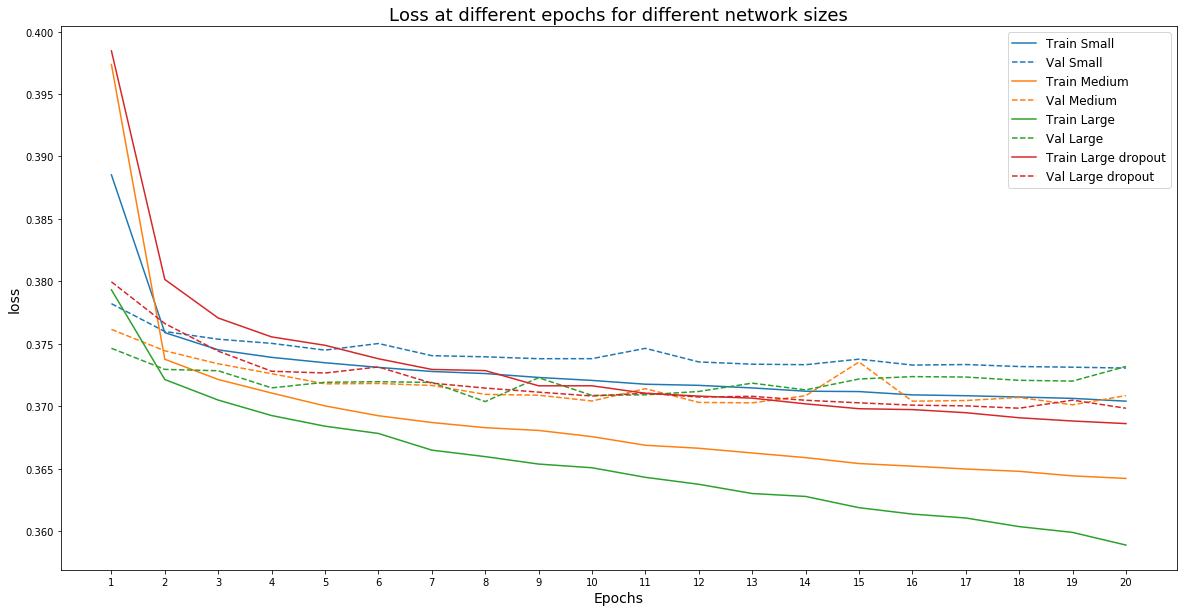

In [73]:
plot_history([('Small', small_network_history),
              ('Medium', med_network_history),
              ('Large', large_network_history),
              ('Large dropout', large_drp_network_history)], key='loss')


*   **From the above plot, we can see that the large network with dropout has good performance on the data and also does not overfit unlike the large network without dropout**


*   **Further evaluation metrics are for large network with dropout model.**





In [74]:
model = large_drp_network_model

In [75]:
loss, accuracy = model.evaluate(test_ds, steps=len(X_test) // batch_size)
print("Accuracy", accuracy)
print("Loss", loss)

100/100 [==============================] - 6s 63ms/step
Accuracy 0.8648399996757508
Loss 0.36741640776395795


In [ ]:
prediction = model.predict(test_ds, steps=len(X_test) // batch_size)

## Checking performance at different thresholds

In [77]:
prediction = prediction.flatten()
y_true = np.asarray(y_test)

threshold_metrics = {}
for threshold in [x/10 for x in range(1,10)]:
    threshold_metrics[threshold]={}
    pred = (prediction >= threshold).astype('int')
    threshold_metrics[threshold]['accuracy'] = accuracy_score(y_true, pred)
    threshold_metrics[threshold]['precision'] = precision_score(y_true, pred)
    threshold_metrics[threshold]['recall'] = recall_score(y_true, pred)
    threshold_metrics[threshold]['f1'] = f1_score(y_true, pred)

/usr/local/lib64/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib64/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [78]:
threshold_metrics = pd.DataFrame(threshold_metrics).T
threshold_metrics

,accuracy,f1,precision,recall
0.1,0.47989,0.303744,0.185789,0.831928
0.2,0.77783,0.324650,0.277259,0.391582
0.3,0.84968,0.188425,0.357216,0.127961
0.4,0.86462,0.047425,0.586087,0.024712
0.5,0.86484,0.029162,0.712281,0.014886
0.6,0.86432,0.012806,0.822430,0.006453
0.7,0.86366,0.000586,0.800000,0.000293
0.8,0.86363,0.000000,0.000000,0.000000
0.9,0.86363,0.000000,0.000000,0.000000


## Removing the 0s at the later values of the thresholds

In [105]:
threshold_metrics.loc[0.8,'f1'] = np.nan
threshold_metrics.loc[0.8,'precision'] = np.nan
threshold_metrics.loc[0.8,'recall'] = np.nan
threshold_metrics.loc[0.9,'f1'] = np.nan
threshold_metrics.loc[0.9,'precision'] = np.nan
threshold_metrics.loc[0.9,'recall'] = np.nan

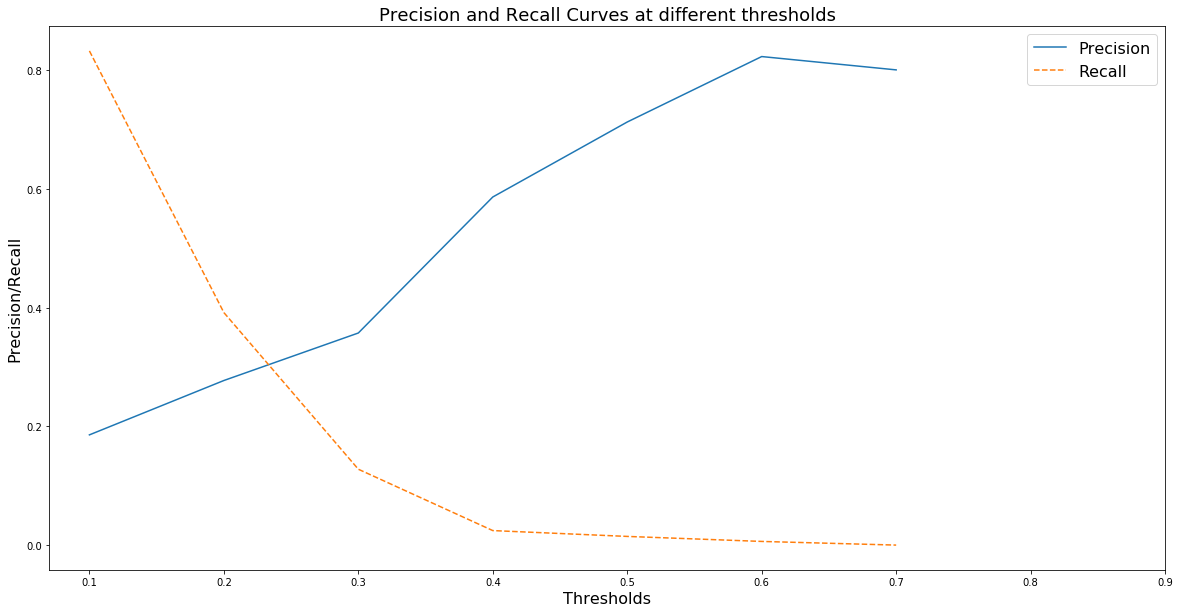

In [106]:
plt.figure(figsize=(20,10))
plt.plot([x/10 for x in range(1,10)], threshold_metrics['precision'],
                 label='Precision')
plt.plot([x/10 for x in range(1,10)], threshold_metrics['recall'], '--',
           label='Recall')
plt.xlabel('Thresholds', fontsize=16)
plt.xticks([x/10 for x in range(1,10)])
plt.ylabel('Precision/Recall', fontsize=16)
plt.legend(loc=1, prop={'size': 16})
plt.title('Precision and Recall Curves at different thresholds', fontsize=18)
plt.show()

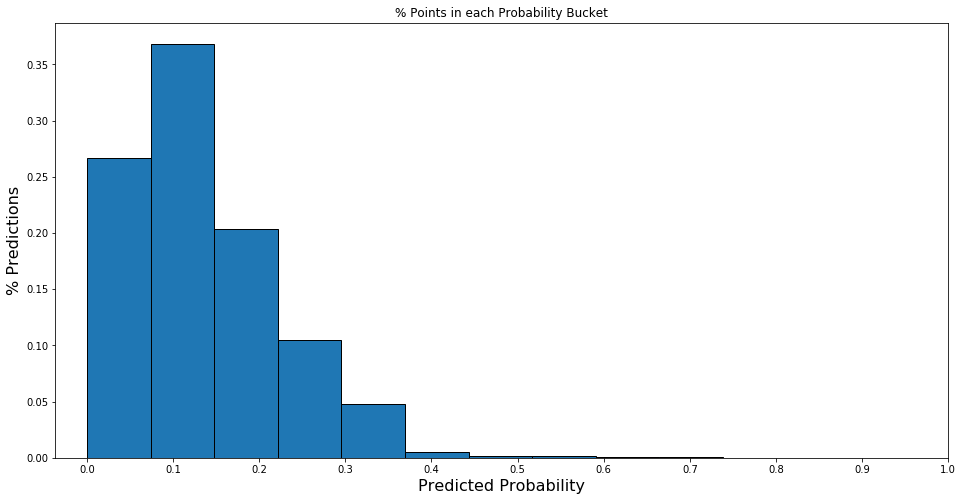

In [80]:
plt.figure(figsize=(16,8))
plt.hist(prediction, edgecolor='Black', weights = np.ones_like(prediction)/float(len(prediction)))
plt.xlabel('Predicted Probability', fontsize=16)
plt.ylabel('% Predictions', fontsize=16)
plt.title('% Points in each Probability Bucket')
plt.xticks([x/10 for x in range(0,11)])
plt.show()

In [116]:
pred_test = (prediction>=0.27).astype('int')
print('Model Precision: {0:.3f}'.format(precision_score(y_true, pred_test)))
print('Model Recall: {0:.3f}'.format(recall_score(y_true, pred_test)))

Model Precision: 0.319
Model Recall: 0.221


### Deep Model with Categorical Embeddings

In [81]:
# Datasets for Embedding
batch_size  = 1000
train_ds_1  = dataset(X_train_1, y_train_1, batch_size=batch_size)
val_ds_1    = dataset(X_val_1, y_val_1, batch_size=batch_size)
test_ds_1   = dataset(X_test_1, y_test_1, shuffle=False, batch_size=batch_size)

In [82]:
feature_layer_embed  = fc.FeatureLayer(all_columns_embed)

In [83]:
model_embed = tf.keras.Sequential([
  feature_layer_embed,
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dropout(rate=0.5), 
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dropout(rate=0.5), 
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [84]:
model_embed.compile(optimizer = tf.train.AdamOptimizer(), loss = tf.keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [85]:
steps_per_epoch_train = len(X_train_1) // batch_size
steps_per_epoch_val = len(X_val_1) // batch_size
print (steps_per_epoch_train)
print (steps_per_epoch_val)

model_history_embed = model_embed.fit(train_ds_1, steps_per_epoch=steps_per_epoch_train, validation_data=val_ds_1, validation_steps=steps_per_epoch_val, epochs=20)

320
80
Epoch 1/20
320/320 [==============================] - 51s 160ms/step - loss: 0.4042 - acc: 0.8591 - val_loss: 0.3871 - val_acc: 0.8613
Epoch 2/20
320/320 [==============================] - 51s 159ms/step - loss: 0.3746 - acc: 0.8622 - val_loss: 0.3697 - val_acc: 0.8621
Epoch 3/20
320/320 [==============================] - 51s 158ms/step - loss: 0.3660 - acc: 0.8630 - val_loss: 0.3650 - val_acc: 0.8631
Epoch 4/20
320/320 [==============================] - 51s 159ms/step - loss: 0.3600 - acc: 0.8639 - val_loss: 0.3624 - val_acc: 0.8632
Epoch 5/20
320/320 [==============================] - 51s 158ms/step - loss: 0.3565 - acc: 0.8642 - val_loss: 0.3605 - val_acc: 0.8633
Epoch 6/20
320/320 [==============================] - 51s 159ms/step - loss: 0.3532 - acc: 0.8645 - val_loss: 0.3602 - val_acc: 0.8635
Epoch 7/20
320/320 [==============================] - 51s 159ms/step - loss: 0.3510 - acc: 0.8647 - val_loss: 0.3606 - val_acc: 0.8636
Epoch 8/20
320/320 [============================

In [86]:
def plot_history(histories, key):
  plt.figure(figsize=(20,10))
    
  for name, history in histories:
    val = plt.plot([x+1 for x in history.epoch], history.history['val_'+key], '--', label='Val '+name.title())
    plt.plot([x+1 for x in history.epoch], history.history[key], color=val[0].get_color(), label='Train '+name.title())

  plt.xlabel('Epochs')
  plt.xticks([x+1 for x in history.epoch])
  plt.ylabel(key.replace('_',' ').title())
  plt.title('Plot of '+ name.title() +' at different Epochs (with Embeddings)', fontsize=18)
  plt.legend()

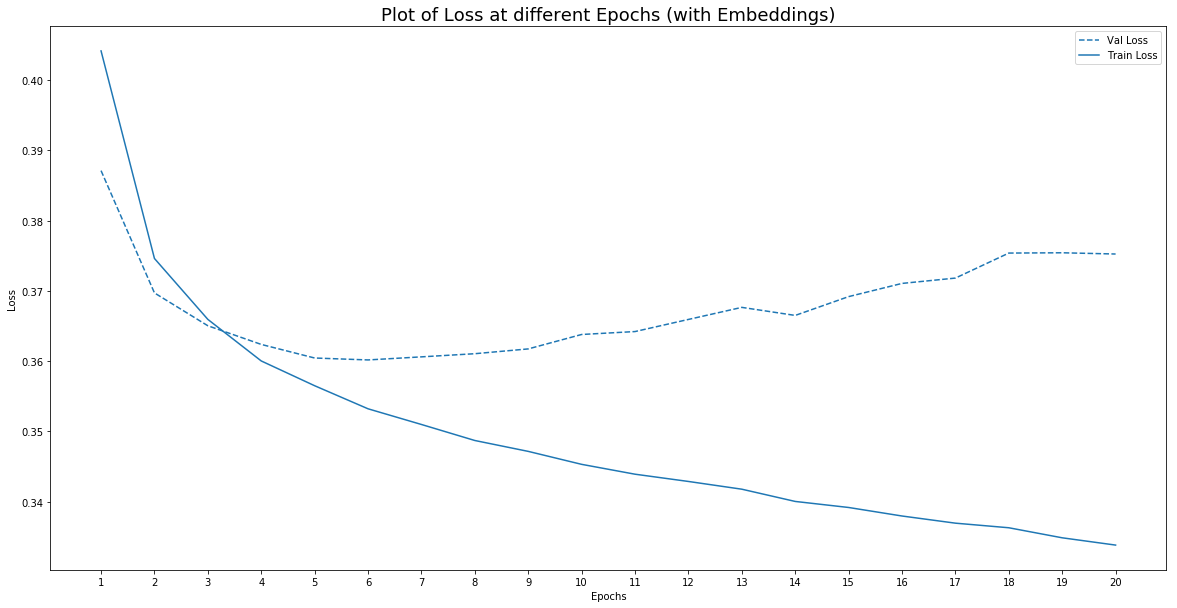

In [87]:
plot_history([('Loss', model_history_embed)],  key='loss')

In [88]:
loss, accuracy = model_embed.evaluate(test_ds_1, steps=len(X_test_1) // batch_size)
print("Accuracy", accuracy)
print("Loss", loss)

100/100 [==============================] - 10s 101ms/step
Accuracy 0.864229998588562
Loss 0.37313068777322767


In [ ]:
prediction_embed = model_embed.predict(test_ds_1, steps=len(X_test_1) // batch_size)

## Checking performance at different thresholds

In [90]:
prediction_embed = prediction_embed.flatten()
y_true_1 = np.asarray(y_test_1)

threshold_metrics_embed = {}
for threshold in [x/10 for x in range(1,10)]:
    threshold_metrics_embed[threshold]={}
    pred_embed = (prediction_embed >= threshold).astype('int')
    threshold_metrics_embed[threshold]['accuracy'] = accuracy_score(y_true_1, pred_embed)
    threshold_metrics_embed[threshold]['precision'] = precision_score(y_true_1, pred_embed)
    threshold_metrics_embed[threshold]['recall'] = recall_score(y_true_1, pred_embed)
    threshold_metrics_embed[threshold]['f1'] = f1_score(y_true_1, pred_embed)

In [91]:
threshold_metrics_embed = pd.DataFrame(threshold_metrics_embed).T
threshold_metrics_embed.round(decimals=3)

,accuracy,f1,precision,recall
0.1,0.531,0.321,0.200,0.810
0.2,0.766,0.355,0.285,0.471
0.3,0.843,0.276,0.375,0.218
0.4,0.861,0.168,0.463,0.102
0.5,0.864,0.095,0.540,0.052
0.6,0.865,0.051,0.632,0.027
0.7,0.864,0.026,0.743,0.013
0.8,0.864,0.015,0.858,0.008
0.9,0.864,0.005,0.900,0.003


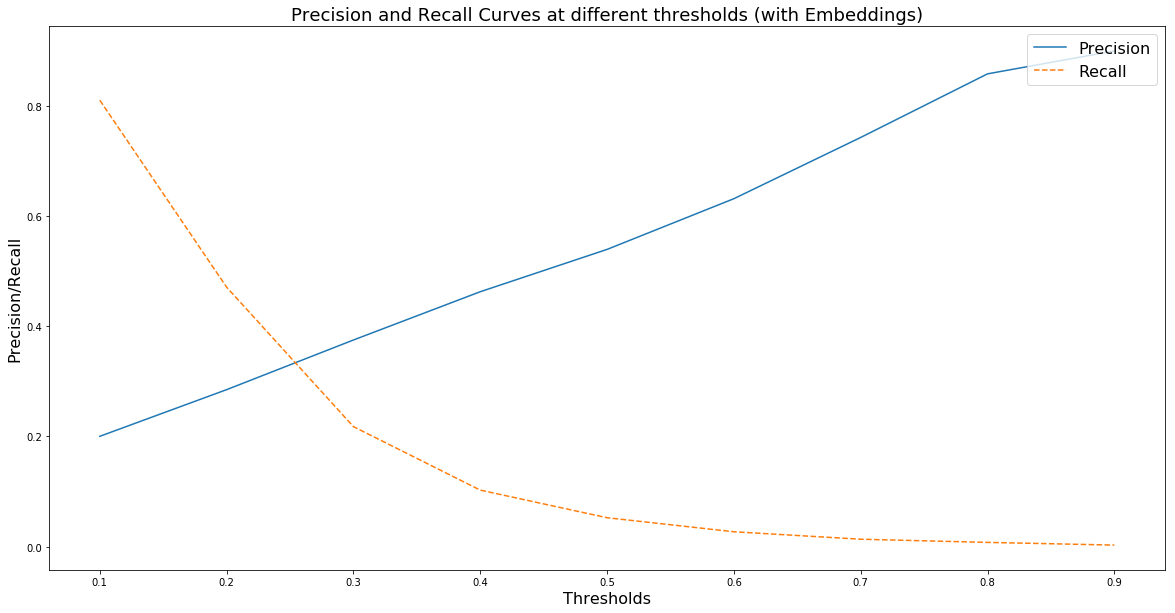

In [93]:
plt.figure(figsize=(20,10))
plt.plot([x/10 for x in range(1,10)], threshold_metrics_embed['precision'], 
                 label='Precision')
plt.plot([x/10 for x in range(1,10)], threshold_metrics_embed['recall'], '--',
           label='Recall')
plt.xlabel('Thresholds', fontsize=16)
plt.xticks([x/10 for x in range(1,10)])
plt.ylabel('Precision/Recall', fontsize=16)
plt.legend(loc=1, prop={'size': 16})
plt.title('Precision and Recall Curves at different thresholds (with Embeddings)', fontsize=18)
plt.show()

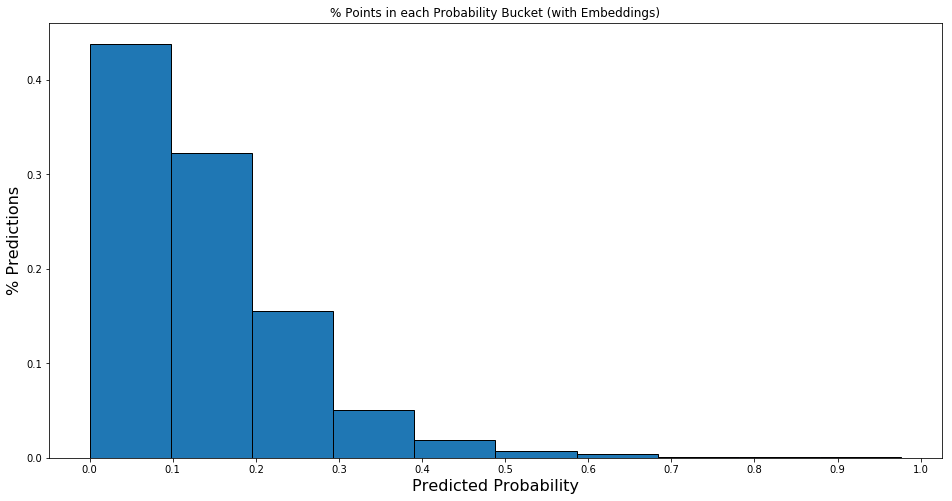

In [94]:
plt.figure(figsize=(16,8))
plt.hist(prediction_embed, edgecolor='Black', weights = np.ones_like(prediction_embed)/float(len(prediction_embed)))
plt.xlabel('Predicted Probability', fontsize=16)
plt.ylabel('% Predictions', fontsize=16)
plt.title('% Points in each Probability Bucket (with Embeddings)')
plt.xticks([x/10 for x in range(0,11)])
plt.show()

In [120]:
pred = (prediction_embed>=0.26).astype('int')
print('Log Loss: {0:.4f}'.format(log_loss(y_test_1, pred)))
print('Accuracy: {0:.4f}'.format(accuracy_score(y_test_1, pred)))
print('Precision: {0:.4f}'.format(precision_score(y_test_1, pred)))
print('Recall: {0:.4f}'.format(recall_score(y_test_1, pred)))
print('F1 Score: {0:.4f}'.format(f1_score(y_test_1, pred)))

Log Loss: 5.9535
Accuracy: 0.8276
Precision: 0.3432
Recall: 0.2842
F1 Score: 0.3109


### Embedding Visualization

In [96]:
# pred_embed
em = model_embed.layers[0].get_weights()[7]
model=TSNE(n_components=2)
a = model.fit_transform(em)

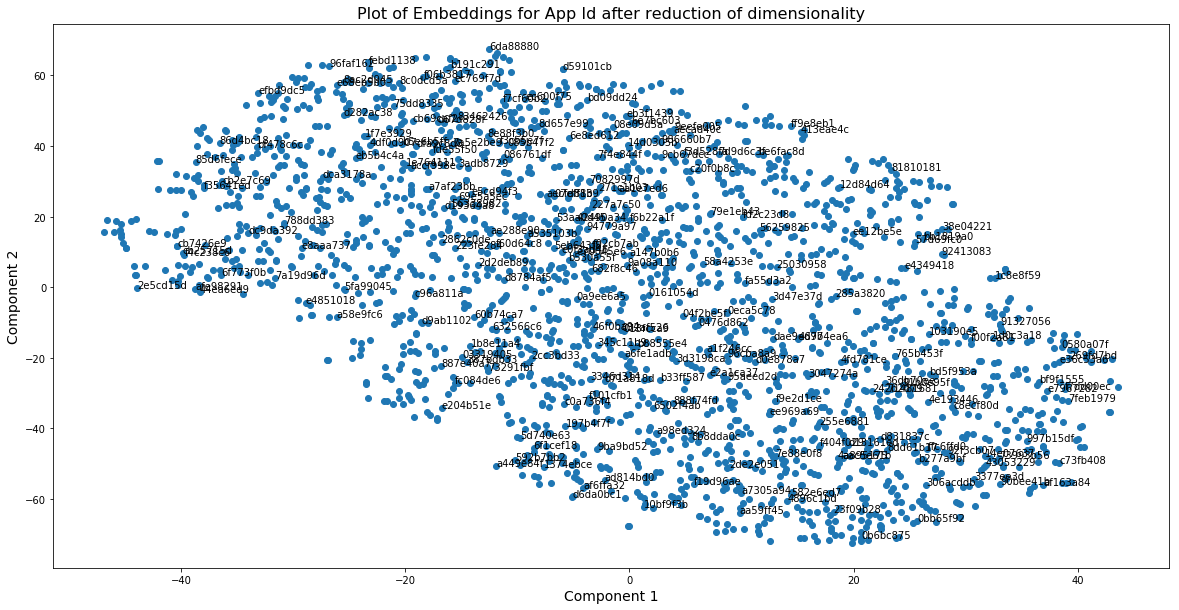

In [97]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(a[:,0], a[:,1])

for i, txt in enumerate(sample_df_1['app_id'].unique()):
    if i%10==0:
        ax.annotate(txt, (a[:,0][i], a[:,1][i]))
        
plt.xlabel('Component 1', fontsize=14)
plt.ylabel('Component 2', fontsize=14)
plt.title('Plot of Embeddings for App Id after reduction of dimensionality', fontsize=16)
plt.show()

## WIDE AND DEEP MODEL

In [128]:
def wd_dataset(X_df, y_df, shuffle=True, batch_size=32, num_epochs=10):
  dataframe = X_df.copy()
  labels = y_df
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.repeat(num_epochs).batch(batch_size) 
  return ds

In [129]:
# Used for Predefined Estimator
def train_inpf(batch_size=1000):
  train_ds = wd_dataset(X_train_1, y_train_1, batch_size=batch_size, num_epochs=10)
  return train_ds

def test_inpf(batch_size=1000):
  test_ds = wd_dataset(X_test_1, y_test_1, shuffle=False, batch_size=batch_size, num_epochs=1)
  return test_ds

In [130]:
# For Wide (Linear Model) use columns without any one hot encoding and embeddings
linear_cols = [hr
              ,C1_1  
              ,C14_1 
              ,C15_1 
              ,C16_1 
              ,C17_1 
              ,C18_1 
              ,C19_1 
              ,C20_1 
              ,C21_1 
              
              ,banner_pos_1    
              
              ,site_id_1       
              ,site_domain_1   
              ,site_category_1 
              
              ,app_id_1        
              ,app_domain_1    
              ,app_category_1  
              
              ,device_model_1  
              ,device_type_1   
              ,device_conn_type_1]
                    

In [131]:
# For Deep Model use one hot encoding and embeddings columns
deep_cols  = [ fc.indicator_column(C1_1),
               fc.indicator_column(C15_1),
               fc.indicator_column(C16_1),
               fc.indicator_column(C18_1),
               fc.indicator_column(device_type_1),
               fc.indicator_column(device_conn_type_1),
               fc.indicator_column(banner_pos_1),
               fc.indicator_column(site_category_1),                     
              
               fc.embedding_column(C14_1, dimension=7),
               fc.embedding_column(C17_1, dimension=5),
               fc.embedding_column(C19_1, dimension=3),
               fc.embedding_column(C20_1, dimension=4),
               fc.embedding_column(C21_1, dimension=3),

               fc.embedding_column(site_id_1, dimension=7), 
               fc.embedding_column(site_domain_1, dimension=9), 

               fc.embedding_column(app_id_1, dimension=8),  
               fc.embedding_column(app_domain_1, dimension=5),                 
               fc.embedding_column(app_category_1, dimension=5), 

               fc.embedding_column(device_model_1, dimension=9)
             ]

In [132]:
wide_deep_model = tf.estimator.DNNLinearCombinedClassifier(  
    # wide settings
    linear_feature_columns = linear_cols,
    linear_optimizer=tf.train.FtrlOptimizer(learning_rate=0.1,
                                            l1_regularization_strength=10.0,
                                            l2_regularization_strength=0.0),
    # deep settings
    dnn_feature_columns = deep_cols,
    dnn_hidden_units=[256, 256],
    dnn_dropout=0.5,
    dnn_activation_fn = tf.nn.relu,  
    dnn_optimizer=tf.train.AdamOptimizer
  )

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_service': None, '_eval_distribute': None, '_global_id_in_cluster': 0, '_experimental_distribute': None, '_task_id': 0, '_log_step_count_steps': 100, '_tf_random_seed': None, '_is_chief': True, '_master': '', '_save_summary_steps': 100, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpo3ez1nb1', '_task_type': 'worker', '_protocol': None, '_train_distribute': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff9e3b184a8>, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_num_worker_replicas': 1, '_num_ps_replicas': 0, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_device_fn': None, '_keep_checkpoint_max': 5}


In [133]:
wide_deep_model.train(train_inpf, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpo3ez1nb1/model.ckpt.
INFO:tensorflow:loss = 751.9164, step = 1
INFO:tensorflow:global_step/sec: 10.8053
INFO:tensorflow:loss = 408.98877, step = 101 (9.256 sec)
INFO:tensorflow:global_step/sec: 38.4801
INFO:tensorflow:loss = 343.68018, step = 201 (2.599 sec)
INFO:tensorflow:global_step/sec: 30.3293
INFO:tensorflow:loss = 345.73862, step = 301 (3.297 sec)
INFO:tensorflow:global_step/sec: 17.5172
INFO:tensorflow:loss = 351.52026, step = 401 (5.709 sec)
INFO:tensorflow:global_step/sec: 43.5705
INFO:tensorflow:loss = 319.76117, step = 501 (2.295 sec)
INFO:tensorflow:global_step/sec: 39.0046
INFO:tensorflow:loss = 364.8899, step = 601 (2.564 sec)
INFO:tensorflow:global_step/sec: 19.3241
INFO:tensorflow:lo

In [134]:
result = wide_deep_model.evaluate(test_inpf, steps = 10)

for key,value in sorted(result.items()):
  print('%s: %s' % (key, value))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-25-00:49:56
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpo3ez1nb1/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/10]
INFO:tensorflow:Evaluation [2/10]
INFO:tensorflow:Evaluation [3/10]
INFO:tensorflow:Evaluation [4/10]
INFO:tensorflow:Evaluation [5/10]
INFO:tensorflow:Evaluation [6/10]
INFO:tensorflow:Evaluation [7/10]
INFO:tensorflow:Evaluation [8/10]
INFO:tensorflow:Evaluation [9/10]
INFO:tensorflow:Evaluation [10/10]
INFO:tensorflow:Finished evaluation at 2018-12-25-00:50:36
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.865, accuracy_baseline = 0.86259997, auc = 0.73747015, auc_precision_recall = 0.31821305, average_loss = 0.35513332, global_step = 1000, label/mean = 0.1374, loss = 355.13333, precision = 0.65, prediction/mean 

In [135]:
prediction_wide_deep = wide_deep_model.predict(test_inpf)

In [136]:
pred_wide_deep_list = []
classes = []

for pred_dict in (prediction_wide_deep):
  class_id = pred_dict['class_ids'][0]
  probability = pred_dict['probabilities'][1]
  
  pred_wide_deep_list.append(probability)
  classes.append(class_id)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpo3ez1nb1/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [137]:
pred_wide_deep_arr = np.array(pred_wide_deep_list)
y_true_1 = np.asarray(y_test_1)

## Checking performance at different thresholds

In [138]:
threshold_metrics_wide_deep = {}
for threshold in [x/10 for x in range(1,10)]:
    threshold_metrics_wide_deep[threshold]={}
    pred_wide_deep = (pred_wide_deep_arr >= threshold).astype('int')
    threshold_metrics_wide_deep[threshold]['accuracy'] = accuracy_score(y_true_1, pred_wide_deep)
    threshold_metrics_wide_deep[threshold]['precision'] = precision_score(y_true_1, pred_wide_deep)
    threshold_metrics_wide_deep[threshold]['recall'] = recall_score(y_true_1, pred_wide_deep)
    threshold_metrics_wide_deep[threshold]['f1'] = f1_score(y_true_1, pred_wide_deep)

/usr/local/lib64/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib64/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [139]:
threshold_metrics_wide_deep = pd.DataFrame(threshold_metrics_wide_deep).T
threshold_metrics_wide_deep.round(decimals=3)

,accuracy,f1,precision,recall
0.1,0.526,0.323,0.201,0.827
0.2,0.770,0.357,0.289,0.467
0.3,0.850,0.234,0.388,0.167
0.4,0.864,0.103,0.534,0.057
0.5,0.865,0.063,0.638,0.033
0.6,0.865,0.047,0.713,0.025
0.7,0.865,0.028,0.771,0.014
0.8,0.864,0.010,0.855,0.005
0.9,0.863,0.000,0.000,0.000


In [145]:
threshold_metrics_wide_deep.loc[0.9,'f1'] = np.nan
threshold_metrics_wide_deep.loc[0.9,'precision'] = np.nan
threshold_metrics_wide_deep.loc[0.9,'recall'] = np.nan

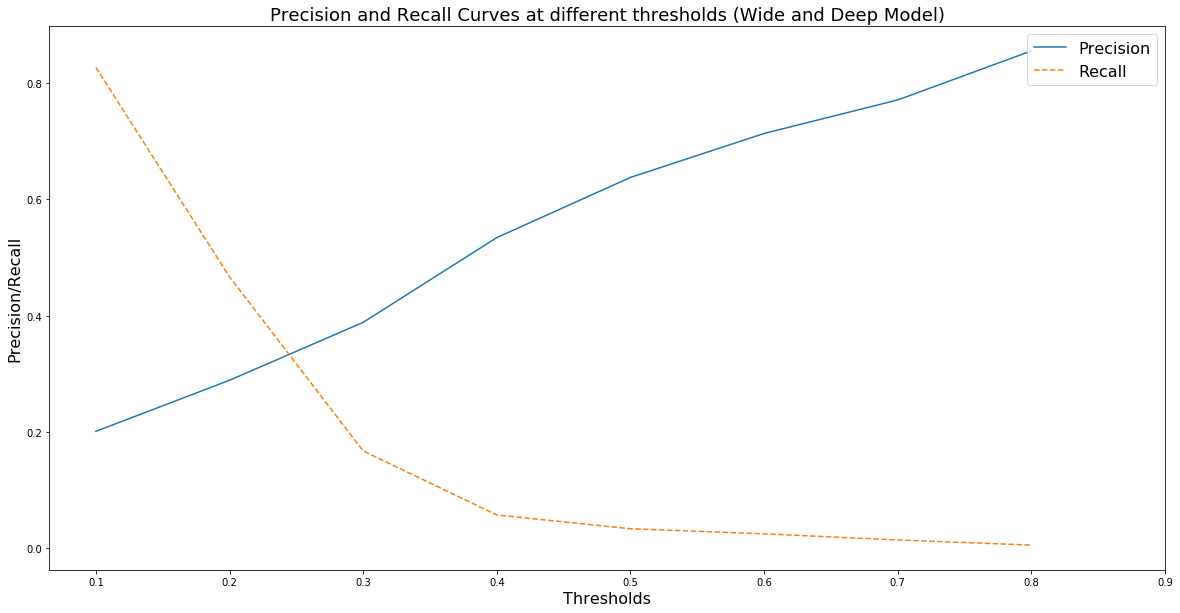

In [146]:
plt.figure(figsize=(20,10))
plt.plot([x/10 for x in range(1,10)], threshold_metrics_wide_deep['precision'], 
                 label='Precision')
plt.plot([x/10 for x in range(1,10)], threshold_metrics_wide_deep['recall'], '--',
           label='Recall')
plt.xlabel('Thresholds', fontsize=16)
plt.xticks([x/10 for x in range(1,10)])
plt.ylabel('Precision/Recall', fontsize=16)
plt.legend(loc=1, prop={'size': 16})
plt.title('Precision and Recall Curves at different thresholds (Wide and Deep Model)', fontsize=18)
plt.show()

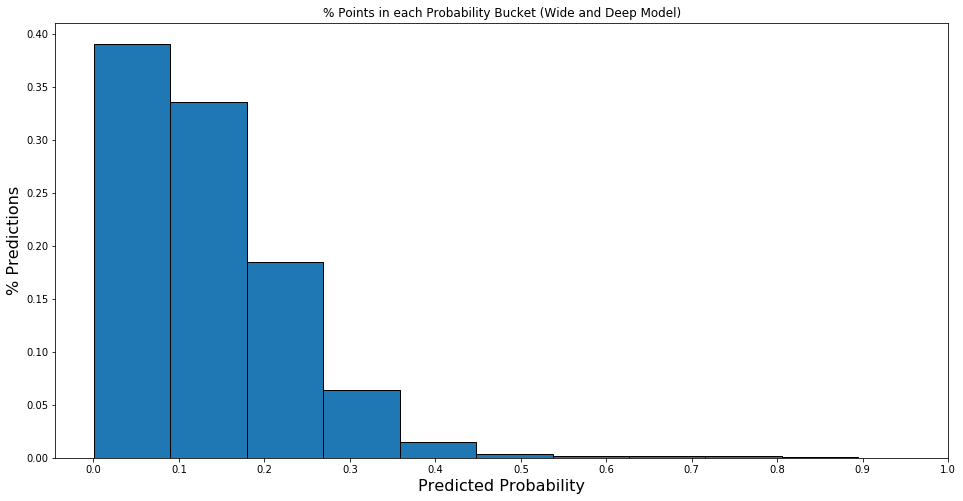

In [141]:
plt.figure(figsize=(16,8))
plt.hist(pred_wide_deep_arr, edgecolor='Black', weights = np.ones_like(pred_wide_deep_arr)/float(len(pred_wide_deep_arr)))
plt.xlabel('Predicted Probability', fontsize=16)
plt.ylabel('% Predictions', fontsize=16)
plt.title('% Points in each Probability Bucket (Wide and Deep Model)')
plt.xticks([x/10 for x in range(0,11)])
plt.show()

## Prediction on the test dataset

In [150]:
pred = (pred_wide_deep_arr>=0.26).astype('int')
print('Log Loss: {0:.4f}'.format(log_loss(y_test_1, pred)))
print('Accuracy: {0:.4f}'.format(accuracy_score(y_test_1, pred)))
print('Precision: {0:.4f}'.format(precision_score(y_test_1, pred)))
print('Recall: {0:.4f}'.format(recall_score(y_test_1, pred)))
print('F1 Score: {0:.4f}'.format(f1_score(y_test_1, pred)))

Log Loss: 5.7932
Accuracy: 0.8323
Precision: 0.3494
Recall: 0.2622
F1 Score: 0.2996
